Реализация CNN модели для задач классификации логотипов компаний

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import os
import requests
from PIL import Image
from io import BytesIO
import csv
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import kagglehub
import pytesseract
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

C:\Users\qwerty142\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Download latest version
path = kagglehub.dataset_download("siddharthkumarsah/logo-dataset-2341-classes-and-167140-images")

print("Path to dataset files:", path)


100%|██████████| 1.91G/1.91G [39:44<00:00, 862kB/s]  

Extracting files...


Path to dataset files: C:\Users\qwerty142\.cache\kagglehub\datasets\siddharthkumarsah\logo-dataset-2341-classes-and-167140-images\versions\1


Далее переведем собранные картинки в csv файл. Чтобы ускорить обучение будем использовать данные только с Accessories

In [44]:
import os
import csv

def process_directory_to_csv(base_dir, output_csv_file, stop_folder="Accessories"):
    data = []
    base_dir = os.path.abspath(base_dir)

    for root, files, _ in os.walk(base_dir):
        
        for file in files:
            
            class_name = file
            fg = os.path.join(root, file)
            
            for root_, files_, __ in os.walk(fg):
                print(__)
                for n in __:
                    full_path = os.path.join(root, file, n).replace("\\", "/")
                    data.append([full_path, class_name])


    with open(output_csv_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["image_path", "class_name"])
        writer.writerows(data)

    print(f"CSV файл сохранен как {output_csv_file}")


base_train_dir = "datasetcopy/trainandtest/train/Accessories"
base_test_dir = "datasetcopy/trainandtest/test/Accessories"
train_csv = "train.csv"
test_csv = "test.csv"


process_directory_to_csv(base_train_dir, train_csv)
process_directory_to_csv(base_test_dir, test_csv)



['1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '4.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '5.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '6.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '7.jpg', '8.jpg', '9.jpg']
['1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', 

Далее представлена модель соостоящая из CNN и OCR В часть с CNN взята предобученная ResNet а для доставания текстовых признаков используется pytesseract

In [24]:
class TransferLearningCNNWithOCR(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningCNNWithOCR, self).__init__()

        self.backbone = models.resnet18(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = False

        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU()
        )

        self.text_fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU()
        )


        self.fc = nn.Sequential(
            nn.Linear(128 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, text_embedding):

        visual_features = self.backbone(image)

        text_features = self.text_fc(text_embedding)

        combined_features = torch.cat((visual_features, text_features), dim=1)

        output = self.fc(combined_features)
        return output

def extract_text_embedding(image_path):

    text = pytesseract.image_to_string(image_path)

    embedding = torch.zeros(128)
    for i, char in enumerate(text[:128]):
        embedding[i] = ord(char) / 256

    return embedding

Далее прдеставлено преборазование собранных файлов и путей в csv файлах в удобный для модели вид

In [25]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_paths = self.data['image_path'].values

        unique_labels = self.data['label'].unique()
        self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

        self.labels = self.data['label'].map(self.label_to_idx).values

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        text_embedding = extract_text_embedding(image_path)

        return image, text_embedding, label


Далее представлена функция для обучения модели, так же тут будут собираться метрики для дальнейшего сравнения показателей треировочной и валидационной выборки

In [26]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)

    # Metrics storage
    metrics = {
        'train': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1_score': []
        },
        'val': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1_score': []
        }
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_labels = []
        train_preds = []

        for images, text_embeddings, labels in train_loader:
            images = images.to(device)
            text_embeddings = text_embeddings.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)

            outputs = model(images, text_embeddings)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(preds.cpu().numpy())

        train_accuracy = accuracy_score(train_labels, train_preds)
        train_precision = precision_score(train_labels, train_preds, average='weighted', zero_division=0)
        train_recall = recall_score(train_labels, train_preds, average='weighted', zero_division=0)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        metrics['train']['accuracy'].append(train_accuracy)
        metrics['train']['precision'].append(train_precision)
        metrics['train']['recall'].append(train_recall)
        metrics['train']['f1_score'].append(train_f1)

        model.eval()
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for images, text_embeddings, labels in val_loader:
                images = images.to(device)
                text_embeddings = text_embeddings.to(device)
                labels = labels.to(device)

                outputs = model(images, text_embeddings)

                _, preds = torch.max(outputs, 1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())

        # Calculate validation metrics
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
        val_recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        metrics['val']['accuracy'].append(val_accuracy)
        metrics['val']['precision'].append(val_precision)
        metrics['val']['recall'].append(val_recall)
        metrics['val']['f1_score'].append(val_f1)

        print(f"Epoch [{epoch + 1}/{num_epochs}]\n"
              f"Train - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}\n"
              f"Val   - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")

    return metrics

Функция для отображения метрик

In [27]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train']['accuracy']) + 1)

    plt.figure(figsize=(12, 8))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics['train']['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(epochs, metrics['val']['accuracy'], label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()

    # Plot precision
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['train']['precision'], label='Train Precision', marker='o')
    plt.plot(epochs, metrics['val']['precision'], label='Val Precision', marker='o')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()

    # Plot recall
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['train']['recall'], label='Train Recall', marker='o')
    plt.plot(epochs, metrics['val']['recall'], label='Val Recall', marker='o')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()

    # Plot F1-Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics['train']['f1_score'], label='Train F1-Score', marker='o')
    plt.plot(epochs, metrics['val']['f1_score'], label='Val F1-Score', marker='o')
    plt.title('F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


Тут происходит само обучение и представление графиков. В начале зададим функция трансформаций изображений. Далее скастим данные. Потом уже проведем обучение.

[ 0  0  0 ... 19 19 19]


C:\Users\qwerty142\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\qwerty142\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\qwerty142\AppData\Local\Temp\ipykernel_22936\560415571.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(devic

Epoch [1/10]
Train - Accuracy: 0.0570, Precision: 0.0256, Recall: 0.0570, F1-Score: 0.0337
Val   - Accuracy: 0.0663, Precision: 0.0311, Recall: 0.0663, F1-Score: 0.0250


C:\Users\qwerty142\AppData\Local\Temp\ipykernel_22936\560415571.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch [2/10]
Train - Accuracy: 0.0845, Precision: 0.0540, Recall: 0.0845, F1-Score: 0.0470
Val   - Accuracy: 0.0969, Precision: 0.2466, Recall: 0.0969, F1-Score: 0.0549


C:\Users\qwerty142\AppData\Local\Temp\ipykernel_22936\560415571.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch [3/10]
Train - Accuracy: 0.0930, Precision: 0.1205, Recall: 0.0930, F1-Score: 0.0594
Val   - Accuracy: 0.1046, Precision: 0.1335, Recall: 0.1046, F1-Score: 0.0586


C:\Users\qwerty142\AppData\Local\Temp\ipykernel_22936\560415571.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch [4/10]
Train - Accuracy: 0.1077, Precision: 0.0959, Recall: 0.1077, F1-Score: 0.0686
Val   - Accuracy: 0.1122, Precision: 0.2449, Recall: 0.1122, F1-Score: 0.0601


C:\Users\qwerty142\AppData\Local\Temp\ipykernel_22936\560415571.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch [5/10]
Train - Accuracy: 0.1000, Precision: 0.1301, Recall: 0.1000, F1-Score: 0.0596
Val   - Accuracy: 0.0969, Precision: 0.2193, Recall: 0.0969, F1-Score: 0.0581


C:\Users\qwerty142\AppData\Local\Temp\ipykernel_22936\560415571.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch [6/10]
Train - Accuracy: 0.1141, Precision: 0.2186, Recall: 0.1141, F1-Score: 0.0723
Val   - Accuracy: 0.1148, Precision: 0.2551, Recall: 0.1148, F1-Score: 0.0659


C:\Users\qwerty142\AppData\Local\Temp\ipykernel_22936\560415571.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch [7/10]
Train - Accuracy: 0.1204, Precision: 0.2122, Recall: 0.1204, F1-Score: 0.0815
Val   - Accuracy: 0.1071, Precision: 0.1390, Recall: 0.1071, F1-Score: 0.0677


C:\Users\qwerty142\AppData\Local\Temp\ipykernel_22936\560415571.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch [8/10]
Train - Accuracy: 0.1070, Precision: 0.1212, Recall: 0.1070, F1-Score: 0.0685
Val   - Accuracy: 0.1224, Precision: 0.2168, Recall: 0.1224, F1-Score: 0.0904


C:\Users\qwerty142\AppData\Local\Temp\ipykernel_22936\560415571.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch [9/10]
Train - Accuracy: 0.1169, Precision: 0.2035, Recall: 0.1169, F1-Score: 0.0860
Val   - Accuracy: 0.1327, Precision: 0.2800, Recall: 0.1327, F1-Score: 0.1084


C:\Users\qwerty142\AppData\Local\Temp\ipykernel_22936\560415571.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch [10/10]
Train - Accuracy: 0.1183, Precision: 0.1694, Recall: 0.1183, F1-Score: 0.0840
Val   - Accuracy: 0.1148, Precision: 0.1874, Recall: 0.1148, F1-Score: 0.0793


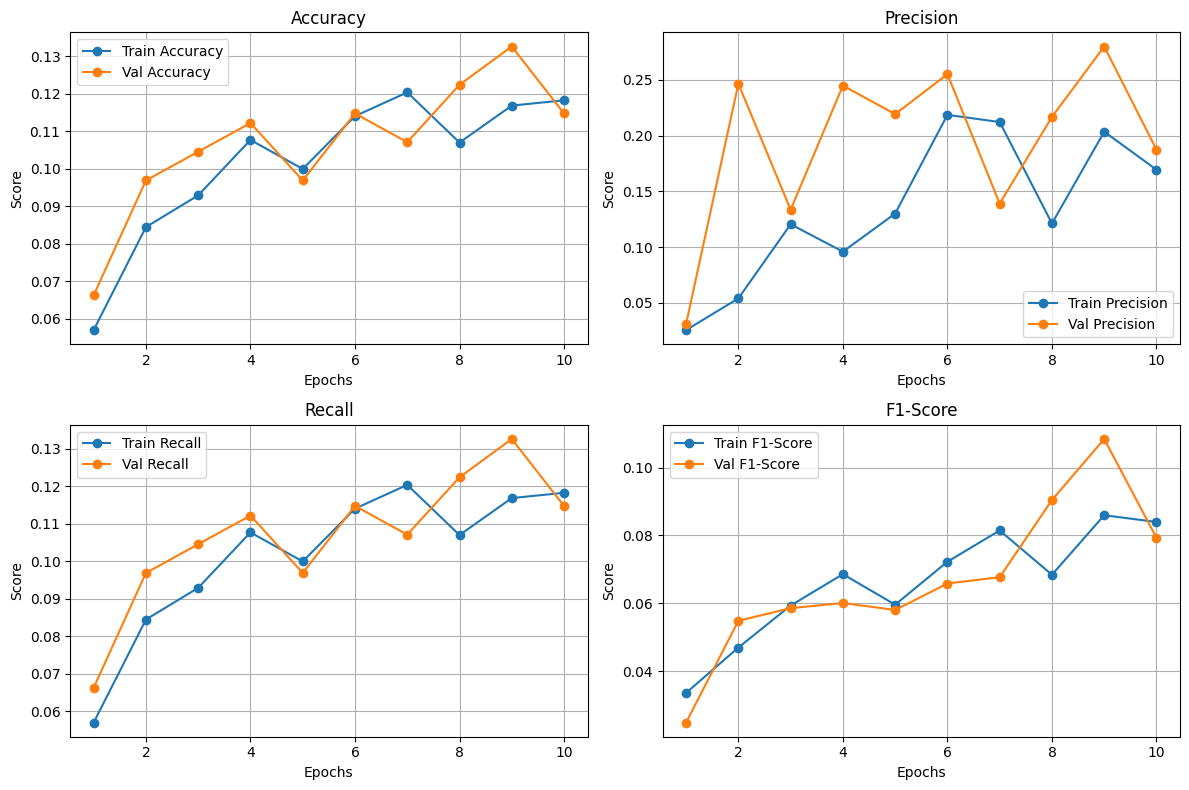

In [28]:
train_csv = "train.csv"
val_csv = "test.csv"


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(train_csv, transform=transform)
print(train_dataset.labels)
val_dataset = CustomDataset(val_csv, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

num_classes = len(pd.read_csv("train.csv")["label"].unique())
model = TransferLearningCNNWithOCR(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

plot_metrics(metrics)

Показатели метрик довольно низкие, однако учитывая то, насколько мал был датасет, их можно считать примлемыми.